In [58]:
import yfinance as yf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error,precision_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [4]:
btc_ticker = yf.Ticker("BTC-USD")

In [5]:
if os.path.exists("btc.csv"):
    btc = pd.read_csv("btc.csv", index_col=0)
else:
    btc = btc_ticker.history(period="max")
    btc.to_csv("btc.csv")

In [6]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-22 00:00:00+00:00,87521.875000,93817.382812,87084.531250,93441.890625,55899038456,0.0,0.0
2025-04-23 00:00:00+00:00,93427.585938,94535.734375,91962.960938,93699.109375,41719568821,0.0,0.0
2025-04-24 00:00:00+00:00,93692.398438,94016.195312,91696.710938,93943.796875,31483175315,0.0,0.0


In [7]:
btc.index = pd.to_datetime(btc.index)

In [8]:
del btc["Dividends"]
del btc["Stock Splits"]

In [9]:
btc.columns = [c.lower() for c in btc.columns]

<Axes: xlabel='Date'>

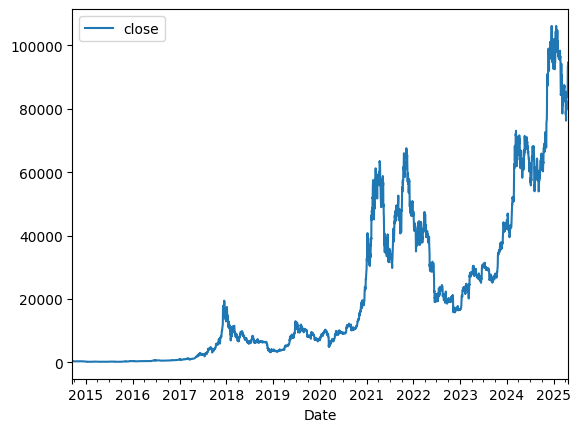

In [10]:
btc.plot.line(y="close", use_index=True)

In [12]:
wiki = pd.read_csv("/content/wikipedia_edits.csv", index_col=0, parse_dates=True)


In [13]:
wiki

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-09-04,0.400000,-0.108480,0.150000
2022-09-05,0.400000,-0.108480,0.150000
2022-09-06,0.433333,-0.081502,0.150000
2022-09-07,0.433333,-0.081502,0.150000


In [17]:
btc.index = btc.index.tz_localize(None)
wiki.index = wiki.index.tz_localize(None)

btc = btc.merge(wiki, left_index=True, right_index=True)


In [18]:
btc["tomorrow"] = btc["close"].shift(-1)

In [19]:
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)

In [20]:
btc["target"].value_counts()

,count
target,
1,1563
0,1351


In [21]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232759,0.532718,394.795990,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0.400000,-0.108480,0.150000,19812.371094,0
2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0.400000,-0.108480,0.150000,18837.667969,0
2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0.433333,-0.081502,0.150000,19290.324219,1
2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,35239757134,0.433333,-0.081502,0.150000,19329.833984,1


In [22]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
train = btc.iloc[:-200]
test = btc.iloc[-200:]
predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [ ]:
predictions["predictions"].value_counts()

,count
predictions,
1,1052
0,767


In [ ]:
precision_score(predictions["target"], predictions["predictions"])

0.5171102661596958

In [ ]:
def compute_rolling(btc):
    horizons = [2,7,60,365]
    new_predictors = ["close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = btc.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        btc[ratio_column] = btc["close"] / rolling_averages["close"]

        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_averages["edit_count"]

        rolling = btc.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        btc[trend_column] = rolling["target"]

        new_predictors+= [ratio_column, trend_column, edit_column]
    return btc, new_predictors

In [ ]:
btc, new_predictors = compute_rolling(btc.copy())

In [ ]:
predictions = backtest(btc, model, new_predictors)

In [ ]:
precision_score(predictions["target"], predictions["predictions"])

0.5240328253223916

In [ ]:
predictions

,target,predictions
2017-09-16,0,0
2017-09-17,1,1
2017-09-18,0,0
2017-09-19,0,1
2017-09-20,0,1
...,...,...
2022-09-04,0,1
2022-09-05,0,1
2022-09-06,1,1
2022-09-07,1,1


In [23]:
def calculate_technical_indicators(df):

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    sma20 = df['Close'].rolling(window=20).mean()
    std20 = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = sma20 + (std20 * 2)
    df['Lower_Band'] = sma20 - (std20 * 2)

    return df



In [25]:
df = btc[['close']].copy()
df.rename(columns={'close': 'Close'}, inplace=True)
df = calculate_technical_indicators(df)

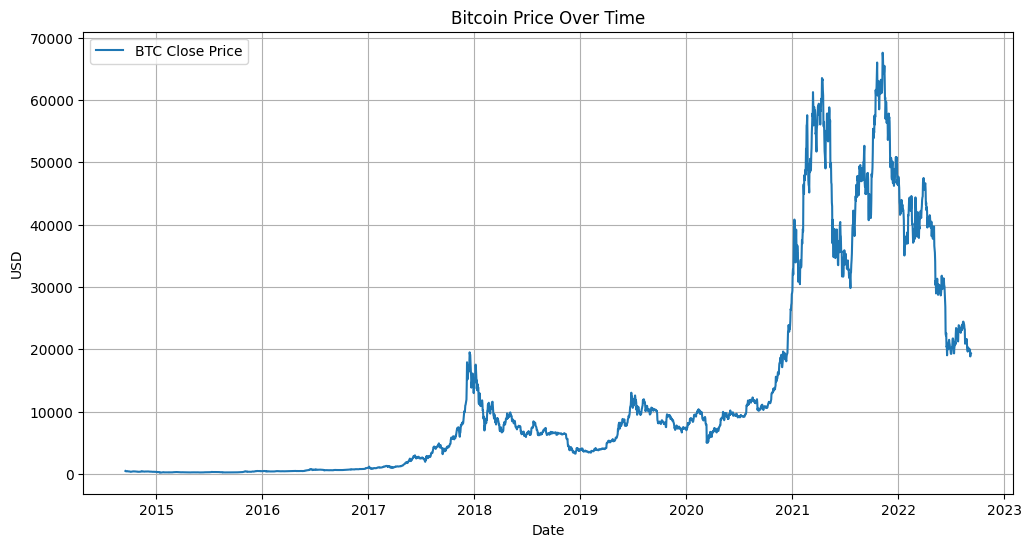

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc['close'], label='BTC Close Price')
plt.title("Bitcoin Price Over Time")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

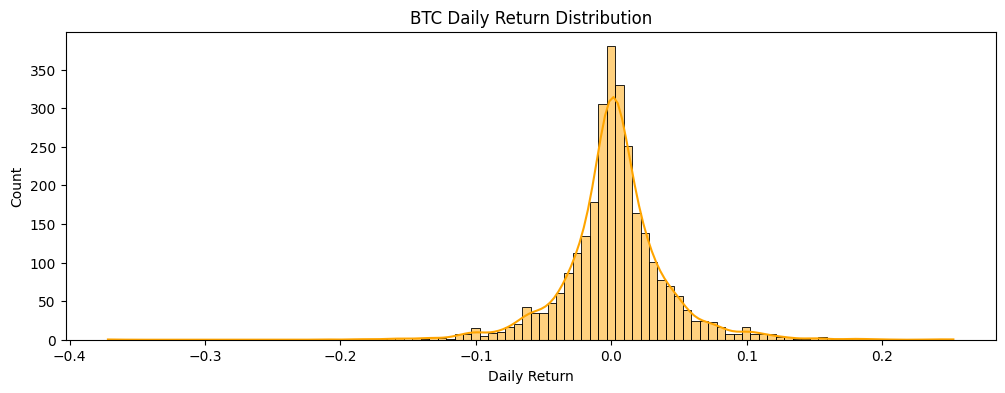

In [ ]:
btc['Daily Return'] = btc['close'].pct_change()
plt.figure(figsize=(12, 4))
sns.histplot(btc['Daily Return'].dropna(), bins=100, kde=True, color='orange')
plt.title("BTC Daily Return Distribution")
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzebhsw_a/2p0wa8qn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzebhsw_a/1yp0nx_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18633', 'data', 'file=/tmp/tmpzebhsw_a/2p0wa8qn.json', 'init=/tmp/tmpzebhsw_a/1yp0nx_u.json', 'output', 'file=/tmp/tmpzebhsw_a/prophet_modelfh85a8_s/prophet_model-20250424080346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:03:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


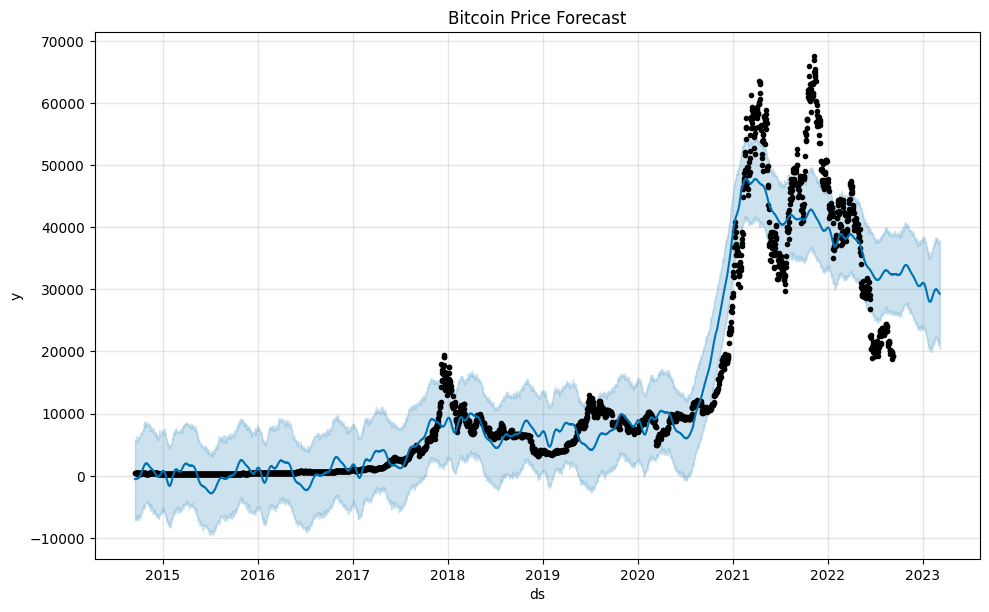

In [ ]:
prophet_df = btc[['close']].reset_index()
prophet_df.columns = ['ds', 'y']
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
fig1 = model.plot(forecast)
plt.title("Bitcoin Price Forecast")
plt.show()


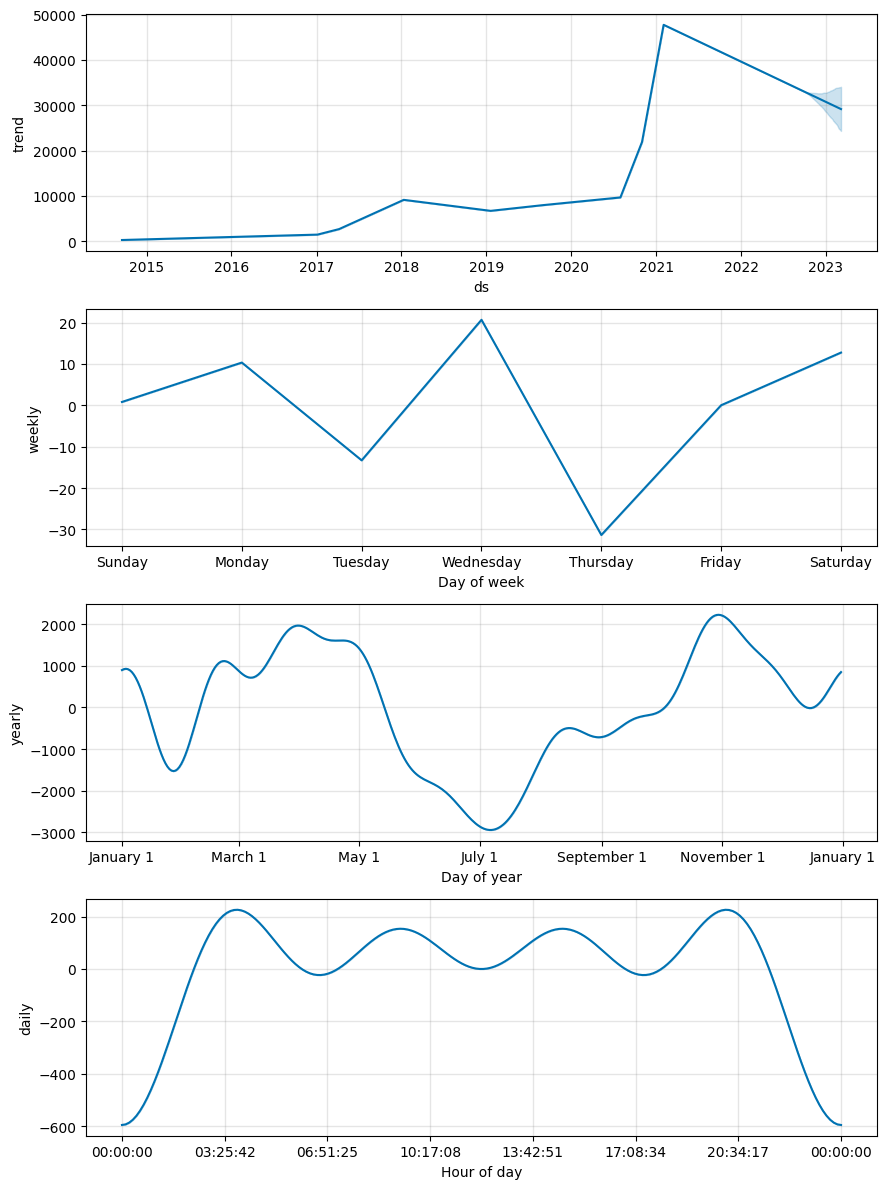

In [ ]:
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
btc = btc[['close']].dropna()
btc = btc.asfreq('D').fillna(method='ffill')
result = adfuller(btc['close'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
btc['logclose'] = np.log(btc['close'])
model = ARIMA(btc['logclose'], order=(5,1,0))
fitted_model = model.fit()
forecast_log = fitted_model.forecast(steps=60)
forecast = np.exp(forecast_log)


ADF Statistic: -1.6745
p-value: 0.4443


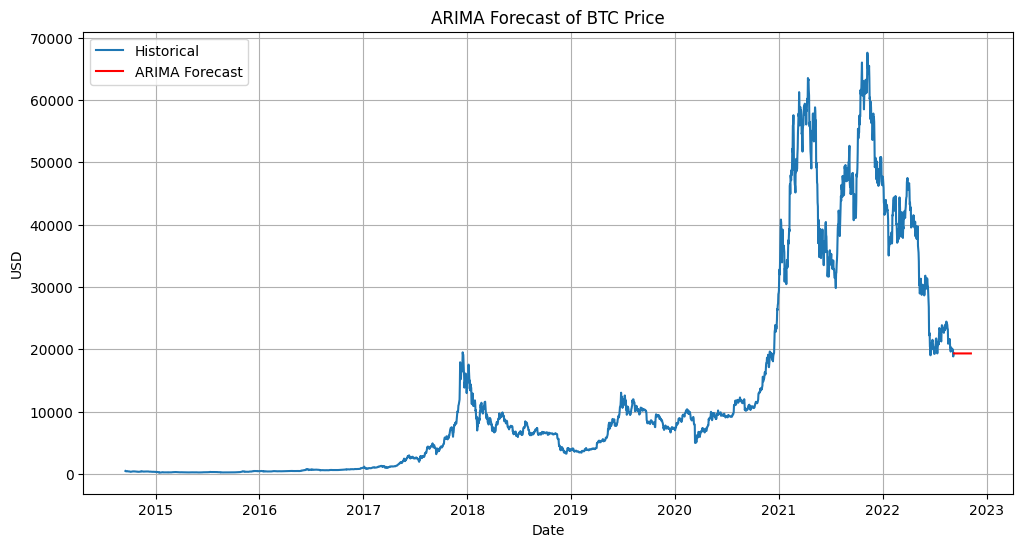

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc['close'], label='Historical')
plt.plot(pd.date_range(start=btc.index[-1], periods=61, freq='D')[1:], forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast of BTC Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close Price',line=dict(color='red')))
fig.add_trace(go.Scatter(x=df.index, y=df['Upper_Band'], mode='lines', name='Upper Band', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=df['Lower_Band'], mode='lines', name='Lower Band', line=dict(color='green')))
fig.update_layout(title='Close Price with Bollinger Bands',xaxis_title='Date',yaxis_title='Price',xaxis_rangeslider_visible=False)
fig.show()

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [36]:
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [38]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1)
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0040
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 2.1379e-04
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 2.0411e-04
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.6833e-04
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.5773e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [39]:
mae = mean_absolute_error(y_test_actual, predicted_price)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_price))
mape = np.mean(np.abs((y_test_actual - predicted_price) / y_test_actual)) * 100
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape:.2f}%')

MAE: 2254.746325730364
RMSE: 2994.54994618957
MAPE: 5.53%


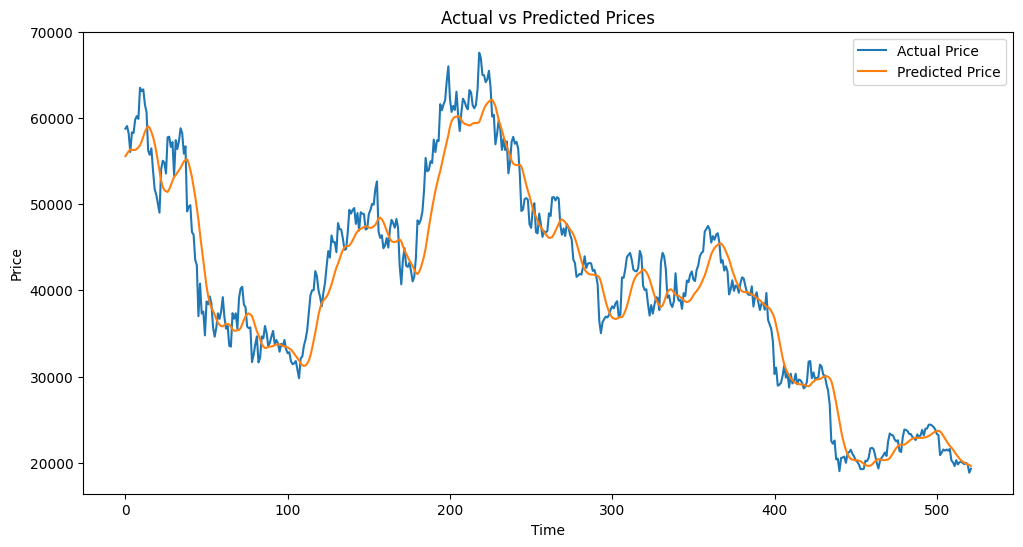

In [41]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predicted_price, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

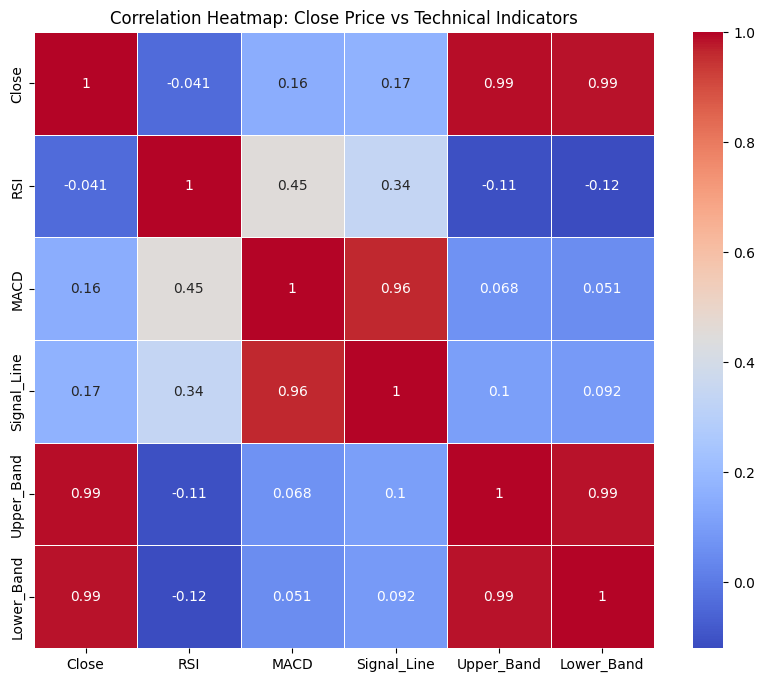

In [44]:
correlation_data = df[['Close', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']]
corr_matrix = correlation_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Close Price vs Technical Indicators')
plt.show()


In [45]:
eth = yf.download('ETH-USD', start='2023-01-01', end='2024-12-31')
sol = yf.download('SOL-USD', start='2023-01-01', end='2024-12-31')
xrp = yf.download('XRP-USD', start='2023-01-01', end='2024-12-31')

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
btc_close = df['Close']
eth_close = btc_close * np.random.uniform(0.05, 0.07, size=len(btc_close))  # ETH is 5%-7% of BTC
sol_close = btc_close * np.random.uniform(0.002, 0.004, size=len(btc_close)) # SOL is 0.2%-0.4%
xrp_close = btc_close * np.random.uniform(0.00001, 0.00002, size=len(btc_close)) # XRP very small %


coins_df = pd.DataFrame({
    'BTC_Close': btc_close.values,
    'ETH_Close': eth_close,
    'SOL_Close': sol_close,
    'XRP_Close': xrp_close
}, index=btc_close.index)


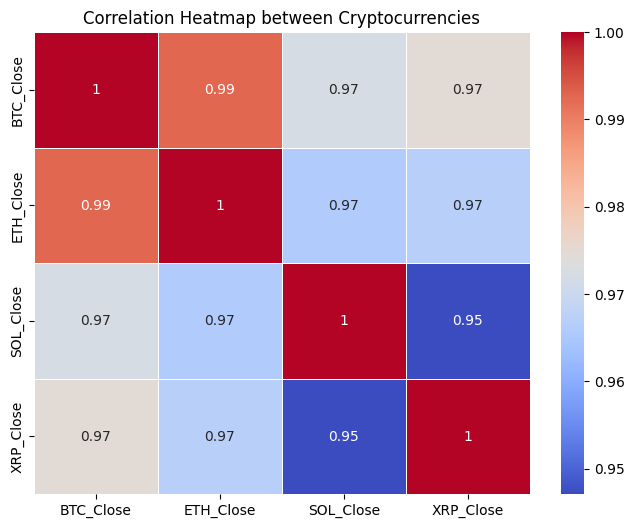

In [53]:
plt.figure(figsize=(8,6))
sns.heatmap(coins_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap between Cryptocurrencies')
plt.show()

In [56]:
corr_matrix = coins_df.corr()
pairs = corr_matrix.unstack()
pairs = pairs[pairs.index.get_level_values(0) != pairs.index.get_level_values(1)]
sorted_pairs = pairs.sort_values(ascending=False)
already_seen = set()
unique_pairs = []

for (coin1, coin2), corr_value in sorted_pairs.items():
    pair = tuple(sorted((coin1, coin2)))
    if pair not in already_seen:
        already_seen.add(pair)
        unique_pairs.append((coin1, coin2, corr_value))

top_3 = unique_pairs[:3]
print("Top 3 Most Correlated Cryptocurrency Pairs:\n")
for coin1, coin2, corr_value in top_3:
    print(f"{coin1} and {coin2} --> Correlation: {corr_value:.2f}")


Top 3 Most Correlated Cryptocurrency Pairs:

BTC_Close and ETH_Close --> Correlation: 0.99
BTC_Close and XRP_Close --> Correlation: 0.97
BTC_Close and SOL_Close --> Correlation: 0.97


In [59]:
corr_matrix = coins_df.corr()
threshold = 0.8
G = nx.Graph()
for coin1 in corr_matrix.columns:
    for coin2 in corr_matrix.columns:
        if coin1 != coin2:
            correlation = corr_matrix.loc[coin1, coin2]
            if correlation >= threshold:
                G.add_edge(coin1, coin2, weight=correlation)

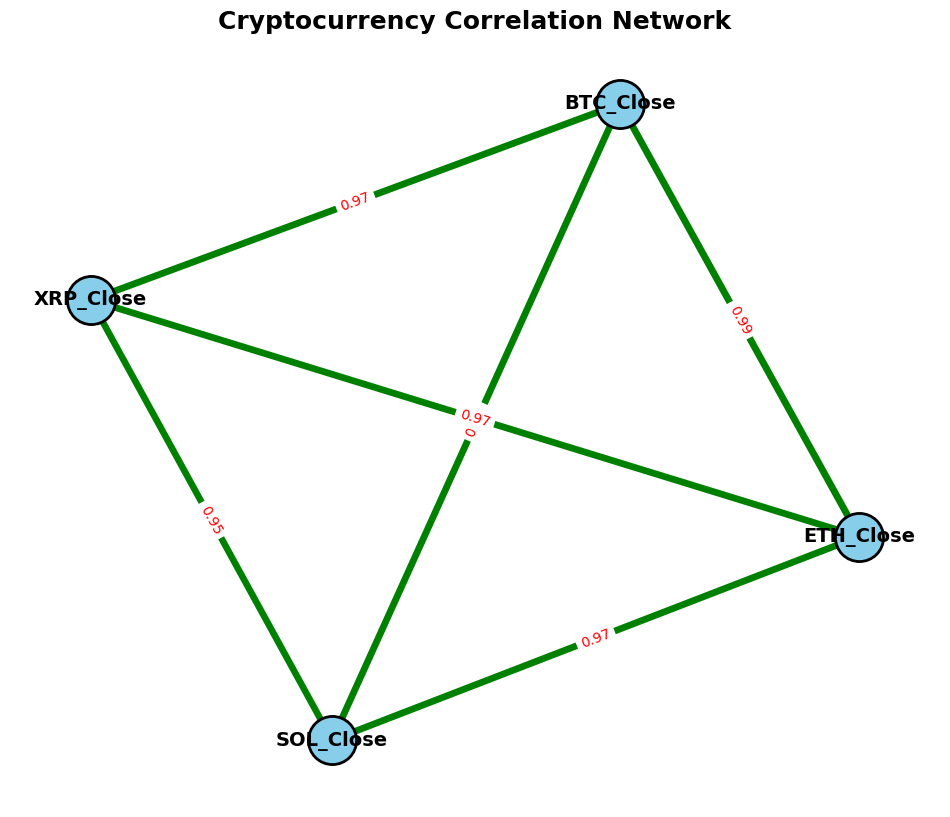

In [66]:
plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
edge_colors = []
edge_widths = []

for (u, v, d) in edges:
    weight = d['weight']
    if weight >= 0.9:
        edge_colors.append('green')
    elif weight >= 0.7:
        edge_colors.append('blue')
    else:
        edge_colors.append('gray')
    edge_widths.append(weight * 5)

nx.draw_networkx_nodes(G, pos,
                       node_color='skyblue',
                       node_size=1200,
                       edgecolors='black',
                       linewidths=2)

nx.draw_networkx_edges(G, pos,
                       edgelist=G.edges(),
                       width=edge_widths,
                       edge_color=edge_colors)

nx.draw_networkx_labels(G, pos,
                        font_size=14,
                        font_family="sans-serif",
                        font_weight='bold')


edge_labels = dict([((u, v), f"{d['weight']:.2f}") for (u, v, d) in edges])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_color='red', font_size=10)
plt.title('Cryptocurrency Correlation Network', fontsize=18, fontweight='bold')
plt.axis('off')
plt.grid(False)
plt.show()